# 使用新baseline,数据库共21个,均为新数据结构

## 读取数据并处理

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(".."))  # 确保当前目录加入路径


In [2]:
import json
import pandas as pd
from pathlib import Path

def load_all_json_to_df(dir_path: str) -> pd.DataFrame:
    """
    输入一个目录路径，将其中所有 JSON 文件中 data["parsed_plans"]
    转换为 DataFrame 并合并。
    假设每个 JSON 文件的结构类似：
        {
          "parsed_plans": [...],
          "database_stats": {...},
          "run_kwargs": {...}
        }
    """
    dir_path = Path(dir_path)
    all_dfs = []

    for fp in dir_path.glob("*.json"):
        try:
            with open(fp, "r") as f:
                data = json.load(f)
            if "parsed_plans" in data:
                df = pd.DataFrame(data["parsed_plans"])
                df["file_name"] = fp.name   # 可选: 标识来源文件
                all_dfs.append(df)
                # print(len(df), ":", fp.name)
            else:
                print(f"⚠️ {fp.name} 没有 parsed_plans 字段")
        except Exception as e:
            print(f"⚠️ 读取 {fp.name} 出错: {e}")

    if not all_dfs:
        print("❌ 没有成功加载任何 JSON 文件")
        return pd.DataFrame()

    df_all = pd.concat(all_dfs, ignore_index=True)
    return df_all

path = "/home/AiChaosN/Project/Phd/project/GNTO/data/runs/parsed_plans/imdb/join_order_full"
df_all = load_all_json_to_df(path)

print(df_all.shape)
print(df_all.head())
print(len(df_all))
df_all.to_csv("../data/process/df01_all.csv", index=False)

(10345, 5)
  plain_content                                    plan_parameters  \
0            []  {'op_name': 'Finalize Aggregate', 'est_startup...   
1            []  {'op_name': 'Finalize Aggregate', 'est_startup...   
2            []  {'op_name': 'Finalize Aggregate', 'est_startup...   
3            []  {'op_name': 'Finalize Aggregate', 'est_startup...   
4            []  {'op_name': 'Finalize Aggregate', 'est_startup...   

                                            children  plan_runtime  \
0  [{'plain_content': [], 'plan_parameters': {'op...     22763.980   
1  [{'plain_content': [], 'plan_parameters': {'op...     18409.769   
2  [{'plain_content': [], 'plan_parameters': {'op...     16737.683   
3  [{'plain_content': [], 'plan_parameters': {'op...     15825.434   
4  [{'plain_content': [], 'plan_parameters': {'op...     25337.844   

           file_name  
0  job_light_22.json  
1  job_light_22.json  
2  job_light_22.json  
3  job_light_22.json  
4  job_light_22.json  
10345


In [3]:
import json
import pandas as pd
from pathlib import Path

def load_and_flatten_json_dir_numeric(dir_path: str, pattern: str = "*.json") -> pd.DataFrame:
    """
    从目录读取所有 JSON（支持单棵/多棵/键值形式的 parsed_plans），
    展开为“每行=一个节点”的 DataFrame，并生成**全数字**ID：
      - plan_id:        int，每棵计划的编号（0..）
      - node_idx:       int，计划内先序编号（0..）
      - parent_idx:     int，父节点在本计划内的 node_idx（根为 -1）
      - global_id:      int，跨所有计划唯一的节点编号（0..）
      - parent_global_id:int，父节点的 global_id（根为 -1）
    还包含：depth, child_order, num_children, op_name 及 plan_parameters 打平列。
    """
    base = Path(dir_path)

    def flatten_one_root(root: dict, plan_id: int, file_name: str, file_path: str,
                         global_start: int):
        """返回 rows(list[dict]) 与本计划的节点数、并补齐 global_id/parent_global_id。"""
        rows = []
        counter = 0  # node_idx 先序编号

        # 先做 DFS 收集“本计划内”的结构（还没有 global_id）
        def dfs(node, parent_idx, depth, child_order):
            nonlocal counter
            node_idx = counter
            counter += 1
            pp = (node.get("plan_parameters") or {})
            row = {k: v for k, v in pp.items()}
            row.update({
                "plan_id": int(plan_id),
                "node_idx": int(node_idx),
                "parent_idx": int(parent_idx),
                "depth": int(depth),
                "child_order": int(child_order),
                "num_children": int(len(node.get("children") or [])),
                "op_name": pp.get("op_name"),
                "file_name": file_name,
                "file_path": file_path,
            })
            rows.append(row)
            for i, ch in enumerate(node.get("children") or []):
                dfs(ch, parent_idx=node_idx, depth=depth+1, child_order=i)

        dfs(root, parent_idx=-1, depth=0, child_order=0)

        # 本计划内 node_idx -> global_id 的映射（连续分配）
        local_to_global = {r["node_idx"]: int(global_start + i) for i, r in enumerate(rows)}

        # 填充 global_id / parent_global_id（纯整数）
        for r in rows:
            r["global_id"] = int(local_to_global[r["node_idx"]])
            if r["parent_idx"] == -1:
                r["parent_global_id"] = int(-1)
            else:
                r["parent_global_id"] = int(local_to_global[r["parent_idx"]])

        return rows, len(rows)

    all_rows = []
    plan_id = 0           # 计划编号（数字）
    global_counter = 0    # 分配 global_id 的递增计数

    for fp in base.rglob(pattern):
        with fp.open("r") as f:
            data = json.load(f)

        parsed = data.get("parsed_plans")

        def handle_root(root):
            nonlocal plan_id, global_counter
            rows, n = flatten_one_root(
                root=root,
                plan_id=plan_id,
                file_name=fp.name,
                file_path=str(fp),
                global_start=global_counter
            )
            all_rows.extend(rows)
            plan_id += 1
            global_counter += n

        # 支持三种形态：单棵树 / 列表 / 键值对
        if isinstance(parsed, dict) and "plan_parameters" in parsed:
            handle_root(parsed)
        elif isinstance(parsed, list):
            for root in parsed:
                if isinstance(root, dict) and "plan_parameters" in root:
                    handle_root(root)
        elif isinstance(parsed, dict):
            for _, root in parsed.items():
                if isinstance(root, dict) and "plan_parameters" in root:
                    handle_root(root)

    return pd.DataFrame(all_rows)

root_dir = "/home/AiChaosN/Project/Phd/project/GNTO/data/runs/parsed_plans/imdb/join_order_full"
df_nodes = load_and_flatten_json_dir_numeric(root_dir)

# 检查都是整数
print(df_nodes[["plan_id","node_idx","parent_idx","global_id","parent_global_id"]].dtypes)

# 简查父子引用是否一致
def verify(df):
    for pid, g in df.groupby("plan_id"):
        s = set(g["node_idx"])
        assert all((p == -1 or p in s) for p in g["parent_idx"])
    gidset = set(df["global_id"])
    assert all((p == -1 or p in gidset) for p in df["parent_global_id"])
    print("OK")

verify(df_nodes)
df_nodes.to_csv("../data/process/df02_nodes.csv", index=False)
df_nodes.keys()


plan_id             int64
node_idx            int64
parent_idx          int64
global_id           int64
parent_global_id    int64
dtype: object
OK


Index(['op_name', 'est_startup_cost', 'est_cost', 'est_card', 'est_width',
       'act_startup_cost', 'act_time', 'act_card', 'output_columns',
       'act_children_card', 'est_children_card', 'workers_planned', 'plan_id',
       'node_idx', 'parent_idx', 'depth', 'child_order', 'num_children',
       'file_name', 'file_path', 'global_id', 'parent_global_id', 'table',
       'filter_columns', 'inner_unique'],
      dtype='object')

In [4]:
cols = [
    # id
    "global_id", "parent_global_id",
    # nodetype
    "op_name",
    # 估计行数 / 行宽
    "est_card", "est_width",
    # plan cost 
    "est_cost", 
    # 谓词 (predicate)
    "filter_columns",
    # 实际时间
    "act_time",
]

df_selected = df_nodes[cols]
print(df_selected.head())
df_selected.to_csv("../data/process/df03_nodes.csv", index=False)


   global_id  parent_global_id                   op_name   est_card  \
0          0                -1        Finalize Aggregate        1.0   
1          1                 0                    Gather        2.0   
2          2                 1         Partial Aggregate        1.0   
3          3                 2                Merge Join  3130140.0   
4          4                 3  Parallel Index Only Scan  1053491.0   

   est_width    est_cost filter_columns   act_time  
0        8.0  2749680.50            NaN  22741.392  
1        8.0  2749680.48            NaN  22741.386  
2        8.0  2748680.28            NaN  22666.461  
3        0.0  2740854.92            NaN  22268.022  
4        4.0    59145.23            NaN    132.477  


In [5]:
import re
import math
from typing import Dict, Any, List, Tuple, Optional

# 1) 操作符词表（自行按需要扩展）
OP2ID = {
    "=": 1, "!=": 2, "<": 3, "<=": 4, ">": 5, ">=": 6,
    "LIKE": 7, "IN": 8, "IS": 9, "IS NULL": 10, "IS NOT NULL": 11,
    # 逻辑运算符对聚合方式重要，但对“原子编码”不纳入；用于树展开时识别
    "AND": -1, "OR": -2, "NOT": -3,
}

# 2) 简单判断 RHS 是否是 "schema.col" 形式（列-列谓词）
COLDOT_RE = re.compile(r"^[A-Za-z_][A-Za-z0-9_]*\.[A-Za-z_][A-Za-z0-9_]*\s*$")

def _is_colref(s: str) -> bool:
    return bool(COLDOT_RE.match(s.strip())) if isinstance(s, str) else False

def _to_float(s: Any) -> Optional[float]:
    try:
        if isinstance(s, str): s = s.strip()
        return float(s)
    except Exception:
        return None

# 3) 把 filter_columns 这棵树“抽叶子”（原子谓词）
def extract_atoms(filter_node: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    返回若干原子谓词，每个元素形如：
    {
        "lhs_col": int or None,
        "op": str,               # 比较运算符，如 '=', '>=', ...
        "rhs_is_col": bool,
        "rhs_col": Optional[int],# 若 rhs 是列，可填解析的列id（没有就 None/自行映射）
        "rhs_literal": Any,      # 若 rhs 是常量
        "literal_feature": Any   # 从原始节点带过来的辅助特征（如果有）
    }
    """
    if not isinstance(filter_node, dict) or not filter_node:
        return []
    op = filter_node.get("operator")

    # 逻辑节点：递归 children
    if op in ("AND", "OR", "NOT"):
        atoms = []
        for ch in (filter_node.get("children") or []):
            atoms.extend(extract_atoms(ch))
        return atoms

    # 叶子：比较节点
    atom = {
        "lhs_col": filter_node.get("column"),
        "op": op,
        "rhs_is_col": False,
        "rhs_col": None,
        "rhs_literal": filter_node.get("literal"),
        "literal_feature": filter_node.get("literal_feature"),
    }

    # 检测 RHS 是否是列引用（例如 "movie_companies.movie_id"）
    rhs = atom["rhs_literal"]
    if isinstance(rhs, str) and _is_colref(rhs):
        atom["rhs_is_col"] = True
        # 这里没有 RHS 的“列ID”，你可以用自己的映射函数把 "schema.col" -> 全局列id
        # 暂时留空或用哈希桶：
        # atom["rhs_col"] = your_colname_to_id(rhs)
        atom["rhs_col"] = None  # 占位
        atom["rhs_literal"] = None

    return [atom]

# 4) 把一个原子谓词编码为数值向量（示例：返回一个 dict，便于后续拼接/embedding）
def encode_atom(atom: Dict[str, Any],
                col_id_max: int = 1000,
                hash_buckets: int = 1000) -> Dict[str, float]:
    """
    输出（简单可训练的数值特征，未做 embedding；embedding 可在模型里做）：
      - op_type_id: 比较运算的 ID
      - lhs_col_id: 左列ID（没有则 -1）
      - rhs_is_col: 0/1
      - rhs_col_id: 右列ID（列-列谓词才有，否则 -1）
      - rhs_lit_is_num: 0/1
      - rhs_lit_val: 数值常量（标准化前），没有时 0
      - rhs_lit_bucket: 对字符串常量做 hash bucket（数值常量则为 -1）
      - literal_feature: 原 JSON 自带的辅助特征（如果没有就 -1 或 0）
    你也可以把 col_id 映射到 embedding（建议在模型里 Embedding）。
    """
    op_type_id = OP2ID.get(atom.get("op"), 0)
    lhs_col = atom.get("lhs_col")
    lhs_col_id = int(lhs_col) if isinstance(lhs_col, int) else -1

    rhs_is_col = 1 if atom.get("rhs_is_col") else 0
    rhs_col_id = int(atom.get("rhs_col")) if isinstance(atom.get("rhs_col"), int) else -1

    rhs_lit = atom.get("rhs_literal")
    rhs_num = _to_float(rhs_lit)
    rhs_lit_is_num = 1 if rhs_num is not None else 0

    # 如果是数值常量，用原值（可在后续做归一化/分桶）
    rhs_lit_val = rhs_num if rhs_num is not None else 0.0

    # 如果是字符串常量，做哈希桶（避免维度爆炸）
    if rhs_num is None and isinstance(rhs_lit, str):
        rhs_lit_bucket = hash(rhs_lit.strip()) % hash_buckets
    else:
        rhs_lit_bucket = -1  # 非字符串或没有

    lit_feat = atom.get("literal_feature")
    if lit_feat is None:
        lit_feat = -1

    return {
        "op_type_id": float(op_type_id),
        "lhs_col_id": float(lhs_col_id),
        "rhs_is_col": float(rhs_is_col),
        "rhs_col_id": float(rhs_col_id),
        "rhs_lit_is_num": float(rhs_lit_is_num),
        "rhs_lit_val": float(rhs_lit_val),
        "rhs_lit_bucket": float(rhs_lit_bucket),
        "literal_feature": float(lit_feat),
    }

# 5) 多个原子如何合并成“一个节点向量”
def aggregate_atoms(atom_vecs: List[Dict[str, float]], mode: str = "mean") -> Dict[str, float]:
    """
    对同一节点的多个原子向量做聚合（mean/max/sum）。
    输出同样是一个 dict（每个键聚合一次）。
    """
    if not atom_vecs:
        # 没有谓词时，给一个“空”的标志（例如全 0）
        return {}
    keys = atom_vecs[0].keys()
    agg = {}
    for k in keys:
        vals = [av[k] for av in atom_vecs]
        if mode == "mean":
            agg[k] = sum(vals) / max(len(vals), 1)
        elif mode == "max":
            agg[k] = max(vals)
        elif mode == "sum":
            agg[k] = sum(vals)
        else:
            agg[k] = sum(vals) / max(len(vals), 1)
    # 可附加一个“有谓词”的二值位
    agg["has_predicate"] = 1.0
    return agg

def encode_filter_to_vector(filter_node: Dict[str, Any],
                            mode: str = "mean") -> Dict[str, float]:
    """
    主入口：把一个 filter_columns 的树 -> 单个节点向量（通过聚合）
    """
    atoms = extract_atoms(filter_node)
    atom_vecs = [encode_atom(a) for a in atoms]
    if not atom_vecs:
        return {"has_predicate": 0.0}  # 无谓词
    return aggregate_atoms(atom_vecs, mode=mode)

def apply_encode(df):
    vecs = df["filter_columns"].apply(encode_filter_to_vector)
    # 展开成多列（与原 df 合并）
    pred_df = pd.DataFrame(list(vecs)).fillna(0)
    return pd.concat([df, pred_df], axis=1)

In [6]:
import numpy as np
import pandas as pd

# 1 复制一份，避免视图问题
df_processed = df_selected[["global_id", "parent_global_id", "op_name", "est_card", "est_width", "est_cost", "filter_columns", "act_time"]].copy()

# 2️ op_name → index
df_processed["op_name"] = df_processed["op_name"].astype(str).str.strip().str.upper()
unique_ops = df_processed["op_name"].unique()
node_type = {op: i for i, op in enumerate(unique_ops)}   # 从 0 开始编号
df_processed["op_name_id"] = df_processed["op_name"].map(node_type)
col_pos = df_processed.columns.get_loc("op_name") + 1
col = df_processed.pop("op_name_id")   # 取出列
df_processed.insert(col_pos, "op_name_id", col)

# 3 数值特征 log 变换
for col in ["est_card", "est_width", "est_cost"]:
    df_processed[col] = np.log1p(df_processed[col].fillna(0))

# 4 谓词处理.删除filter_columns
vecs = df_selected["filter_columns"].apply(encode_filter_to_vector)
pred_df = pd.DataFrame(list(vecs)).fillna(0)
df_processed = pd.concat([df_processed, pred_df], axis=1)
df_processed = df_processed.drop(columns=["filter_columns"])


# 4 保存结果
out_path = "../data/process/df04_nodes.csv"
df_processed.to_csv(out_path, index=False)
print(f"✅ Saved processed node features to {out_path}, shape={df_processed.shape}")


✅ Saved processed node features to ../data/process/df04_nodes.csv, shape=(175272, 17)


In [7]:
# 5 最后筛选出必要的
cols = [
    "global_id", "parent_global_id",
    "op_name_id",
    "est_card",
    "est_width", "est_cost",
    "has_predicate", "op_type_id", "lhs_col_id", "rhs_is_col", "rhs_col_id", "rhs_lit_is_num", "rhs_lit_val", "rhs_lit_bucket", "literal_feature",
    "act_time",
]
df_processed_final = df_processed[cols]
df_processed_final.to_csv("../data/process/df05_nodes.csv", index=False)

# 构建数据集

In [8]:
df_processed_final.keys()

Index(['global_id', 'parent_global_id', 'op_name_id', 'est_card', 'est_width',
       'est_cost', 'has_predicate', 'op_type_id', 'lhs_col_id', 'rhs_is_col',
       'rhs_col_id', 'rhs_lit_is_num', 'rhs_lit_val', 'rhs_lit_bucket',
       'literal_feature', 'act_time'],
      dtype='object')

In [9]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = df_processed_final.copy()
df["global_id"] = df["global_id"].astype(int)
df["parent_global_id"] = df["parent_global_id"].astype(int)
df = df.fillna(0.0)

graphs = []

# 没有 plan_id 时自动标注
if "plan_id" not in df.columns:
    roots = df[df["parent_global_id"] == -1]["global_id"].tolist()
    plan_id_map = {}
    for pid, root_id in enumerate(roots):
        stack = [root_id]
        while stack:
            nid = stack.pop()
            plan_id_map[nid] = pid
            children = df[df["parent_global_id"] == nid]["global_id"].tolist()
            stack.extend(children)
    df["plan_id"] = df["global_id"].map(plan_id_map).fillna(-1).astype(int)

for pid, group in df.groupby("plan_id"):
    group = group.sort_values("global_id").reset_index(drop=True)
    gid2nid = {gid: i for i, gid in enumerate(group["global_id"])}

    # --- ID 类（long）---
    op_name_id     = torch.as_tensor(group["op_name_id"].values, dtype=torch.long)
    op_type_id     = torch.as_tensor(group["op_type_id"].values, dtype=torch.long)
    lhs_col_id     = torch.as_tensor(group["lhs_col_id"].values, dtype=torch.long)
    rhs_col_id     = torch.as_tensor(group["rhs_col_id"].values, dtype=torch.long)
    rhs_lit_bucket = torch.as_tensor(group["rhs_lit_bucket"].values, dtype=torch.long)

    # --- 谓词门控 & 数值（按 NodeEncoder_V3 的需求分别提供）---
    rhs_is_col      = torch.as_tensor(group["rhs_is_col"].values, dtype=torch.long)        # 0/1
    rhs_lit_is_num  = torch.as_tensor(group["rhs_lit_is_num"].values, dtype=torch.long)    # 0/1
    rhs_lit_val     = torch.as_tensor(group["rhs_lit_val"].values, dtype=torch.float)      # 已 log/标准化

    # --- 其它数值特征拼成 x_num（与 NodeEncoder_V3.num_proj 输入维度一致）---
    # 建议顺序固定: [est_card, est_width, est_cost, has_predicate, rhs_is_col, rhs_lit_is_num, rhs_lit_val, literal_feature]
    x_num = torch.as_tensor(
        group[[
            "est_card","est_width","est_cost","has_predicate",
            "rhs_is_col","rhs_lit_is_num","rhs_lit_val","literal_feature"
        ]].values,
        dtype=torch.float
    )

    # 边（父↔子双向）
    edges = []
    for _, r in group.iterrows():
        p_g = r["parent_global_id"]
        c_g = r["global_id"]
        if p_g == -1: 
            continue
        if p_g in gid2nid and c_g in gid2nid:
            p = gid2nid[p_g]; c = gid2nid[c_g]
            edges.append([p, c]); edges.append([c, p])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0), dtype=torch.long)

    # 根 y
    root_y = group.loc[group["parent_global_id"] == -1, "act_time"].values
    if len(root_y) == 0:
        continue
    y = torch.tensor(root_y, dtype=torch.float)  # 形状 [1]

    data = Data(
        # IDs
        op_name_id=op_name_id,
        op_type_id=op_type_id,
        lhs_col_id=lhs_col_id,
        rhs_col_id=rhs_col_id,
        rhs_lit_bucket=rhs_lit_bucket,
        # predicate gates/values
        rhs_is_col=rhs_is_col,
        rhs_lit_is_num=rhs_lit_is_num,
        rhs_lit_val=rhs_lit_val,
        # numerics
        x_num=x_num,
        # graph
        edge_index=edge_index,
        y=y
    )
    graphs.append(data)

print(f"共构造 {len(graphs)} 个图样本")

# 先打乱再划分
indices = np.arange(len(graphs))
np.random.shuffle(indices)
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = [graphs[i] for i in train_idx]
val_dataset   = [graphs[i] for i in val_idx]
test_dataset  = [graphs[i] for i in test_idx]

print("-"*80)
print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")

# 检查（注意：现在打印 x_num 而不是 x）
i = 0
print("="*80)
print("x_num:", train_dataset[i].x_num.shape)      # [N, 8]
print("edge_index:", train_dataset[i].edge_index.shape)
print("y:", train_dataset[i].y)


共构造 10345 个图样本
--------------------------------------------------------------------------------
训练集: 7241, 验证集: 1552, 测试集: 1552
x_num: torch.Size([18, 8])
edge_index: torch.Size([2, 34])
y: tensor([23429.0527])


In [10]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8)
test_loader  = DataLoader(test_dataset,  batch_size=8)


# 搭建模型

In [11]:
# 模型搭建
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch

from models.NodeEncoder import *
from models.TreeEncoder import *
from models.PredictionHead import *
from models.TrainAndEval import EarlyStopping

class CostModel(nn.Module):
    def __init__(self, nodecoder: nn.Module, treeencoder: nn.Module, predict_head: nn.Module):
        super().__init__()
        self.nodecoder = nodecoder
        self.treeencoder = treeencoder
        self.predict_head = predict_head

    def forward(self, data):
        # ✅ 传入完整的 data/Batch，而不是 data.x
        x = self.nodecoder(data)  # NodeEncoder_V3.forward(data)
        batch_vec = getattr(data, "batch", None)
        if batch_vec is None:
            batch_vec = x.new_zeros(x.size(0), dtype=torch.long)
        g = self.treeencoder(x, data.edge_index, batch_vec)
        y = self.predict_head(g)
        return y



num_node_types = int(df_processed_final['op_name_id'].max()) + 1
num_cols       = int(max(df_processed_final['lhs_col_id'].max(),
                         df_processed_final['rhs_col_id'].max())) + 1
num_ops        = int(df_processed_final['op_type_id'].max()) + 1
print(f"vocab: node_types={num_node_types}, cols={num_cols}, ops={num_ops}")

f_in, d_node, d_graph, out_dim = len(train_dataset[0].x_num), 39, 64, 1
nodecoder = NodeEncoder_V3(
    num_node_types=num_node_types,
    num_cols=num_cols, 
    num_ops=num_ops,
    out_dim=d_node,
)
gatTreeEncoder = GATv2TreeEncoder_V3(
    in_dim=d_node,
    hidden_dim=64,
    out_dim=d_graph
)
predict_head = PredictionHead_V2(
    in_dim=d_graph,
    out_dim=out_dim
)

# 重新构建模型
model = CostModel(nodecoder, gatTreeEncoder, predict_head)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(model)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

vocab: node_types=17, cols=75, ops=7
CostModel(
  (nodecoder): NodeEncoder_V3(
    (type_emb): Embedding(17, 16)
    (pred_enc): PredicateEncoderV3(
      (col_emb): Embedding(75, 16)
      (op_emb): Embedding(7, 8)
      (str_emb): Embedding(1000, 8)
      (num_proj): Sequential(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=8, bias=True)
      )
      (fuse): Sequential(
        (0): Linear(in_features=40, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=32, out_features=32, bias=True)
      )
    )
    (num_proj): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
    )
    (proj_in): Linear(in_features=56, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (fc1): Linear(in_features

In [12]:
from datetime import datetime
from models.TrainAndEval import train_epoch, validate_epoch
import time

#  8. 训练循环
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                early_stopping, device, weight_path, num_epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        # 验证
        val_loss, q50, q95 = validate_epoch(model, val_loader, criterion, device)

        # 学习率调度
        scheduler.step(val_loss)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 计算时间
        epoch_time = time.time() - start_time
        
        # 打印进度
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
                  f"Time: {epoch_time:.2f}s")
        
        # 早停检查
        if early_stopping(val_loss, model):
            print(f"\n早停触发在第 {epoch+1} 轮")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            date = datetime.now().strftime("%m%d")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'../results/weight_{date}.pth')
    
        print("-"*100)
    print("-" * 60)
    print("训练完成!")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# 开始训练
date = datetime.now().strftime("%m%d")
weight_path = f'../results/{date}.pth'
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, 
    criterion, early_stopping, device, weight_path, num_epochs=100
)


开始训练...
------------------------------------------------------------


/home/AiChaosN/miniconda3/envs/cs224/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'op_type_id', 'rhs_col_id', 'lhs_col_id', 'op_name_id', 'rhs_lit_is_num', 'rhs_lit_val', 'rhs_lit_bucket', 'x_num', 'edge_index', 'rhs_is_col', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Median: 78.52836807130066
Mean: 80.93177052082095
val_loss: 309548921.979381 | MedianQ: 78.528 | Q90: 130.137 | MeanQ: 80.932
Epoch   1/100 | Train Loss: 310356089.068433 | Val Loss: 309548921.979381 | LR: 1.00e-03 | Time: 16.85s
----------------------------------------------------------------------------------------------------
Median: 25.25672528212788
Mean: 26.029721696274258
val_loss: 295821955.958763 | MedianQ: 25.257 | Q90: 41.855 | MeanQ: 26.030
----------------------------------------------------------------------------------------------------
Median: 12.438863440926854
Mean: 12.822369151899128
val_loss: 275672593.731959 | MedianQ: 12.439 | Q90: 20.614 | MeanQ: 12.822
----------------------------------------------------------------------------------------------------
Median: 7.422264020228761
Mean: 7.657863127619701
val_loss: 250153096.659794 | MedianQ: 7.422 | Q90: 12.300 | MeanQ: 7.658
-------------------------------------------------------------------------------------------

In [13]:
from models.TrainAndEval import evaluate_model

# 评估模型
targets, predictions, metrics = evaluate_model(model, test_loader, device)
 
# 准确度 q50:1.3~1.4左右
# Q50: 1.381, Q90: 2.149, QMean: 1.614


Median: 1.3742007613182068
Mean: 1.6077025340394764

测试集评估结果:
MSE:  46372000.000000
Q50: 1.374, Q90: 2.168, QMean: 1.608


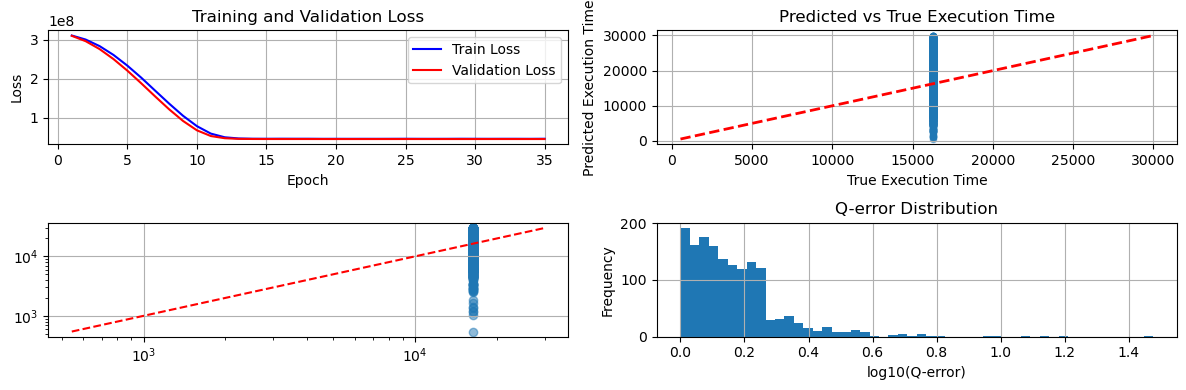

In [14]:

# 10. 可视化训练过程和结果
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))
    
    # 训练损失曲线
    plt.subplot(2, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # 预测 vs 真实值
    plt.subplot(2, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, s=20)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('True Execution Time')
    plt.ylabel('Predicted Execution Time')
    plt.title('Predicted vs True Execution Time')
    plt.grid(True)
    


    # 对数坐标
    plt.subplot(2, 2, 3)
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(targets, predictions, alpha=0.5)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.grid(True)

    # q-error 分布
    plt.subplot(2, 2, 4)
    q_error = np.maximum(predictions/targets, targets/predictions)
    plt.hist(np.log10(q_error), bins=50)
    plt.xlabel("log10(Q-error)")
    plt.ylabel("Frequency")
    plt.title("Q-error Distribution")
    plt.grid(True)

    plt.tight_layout()
    date = datetime.now().strftime("%m%d")
    plt.savefig(f'../results/training_results_{date}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 创建结果目录
os.makedirs('../results', exist_ok=True)
# 绘制结果
plot_training_history(train_losses, val_losses)
